## Project: Creating an Algorithm for a Dog Identification App 


### Why I'm Here 

In this notebook, I will make the first steps towards developing an algorithm that could be used as part of a mobile or web app.  At the end of this project, this code will accept any user-supplied image as input.  If a dog is detected in the image, it will provide an estimate of the dog's breed.  If a human is detected, it will provide an estimate of the dog breed that is most resembling.  The image below displays the output of the finished project:

![Sample Dog Output](images/sample_dog_output.png)

In this real-world setting, we will need to piece together a series of models to perform different tasks; for instance, the algorithm that detects humans in an image will be different from the CNN that infers dog breed.  There are many points of possible failure, and no perfect algorithm exists.  My imperfect solution will nonetheless be a fun experience!

### The Road Ahead

I have broken the notebook into separate steps.  Feel free to use the links below to navigate the notebook.

* [Step 0](#step0): Import Datasets
* [Step 1](#step1): Detect Humans
* [Step 2](#step2): Detect Dogs
* [Step 3](#step3): Create a CNN to Classify Dog Breeds (from Scratch)
* [Step 4](#step4): Create a CNN to Classify Dog Breeds (using Transfer Learning)
* [Step 5](#step5): Write your Algorithm
* [Step 6](#step6): Test Your Algorithm

---
<a id='step0'></a>
## Step 0: Import Datasets

Make sure that you've downloaded the required human and dog datasets:

* Download the [dog dataset](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip).  Unzip the folder and place it in this project's home directory, at the location `/dog_images`. 

* Download the [human dataset](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/lfw.zip).  Unzip the folder and place it in the home directory, at location `/lfw`.  

In the code cell below, we save the file paths for both the human (LFW) dataset and dog dataset in the numpy arrays `human_files` and `dog_files`.

In [1]:
import numpy as np
from glob import glob

# load filenames for human and dog images
human_files = np.array(glob("./data/lfw/*/*"))
dog_files = np.array(glob("./data/dog_images/*/*/*"))

# print number of images in each dataset
print('There are %d total human images.' % len(human_files))
print('There are %d total dog images.' % len(dog_files))

There are 13233 total human images.
There are 8351 total dog images.


<a id='step1'></a>
## Step 1: Detect Humans

In this section, we use OpenCV's implementation of [Haar feature-based cascade classifiers](http://docs.opencv.org/trunk/d7/d8b/tutorial_py_face_detection.html) to detect human faces in images.  

OpenCV provides many pre-trained face detectors, stored as XML files on [github](https://github.com/opencv/opencv/tree/master/data/haarcascades).  We have downloaded one of these detectors and stored it in the `haarcascades` directory.  In the next code cell, we demonstrate how to use this detector to find human faces in a sample image.

Number of faces detected: 1


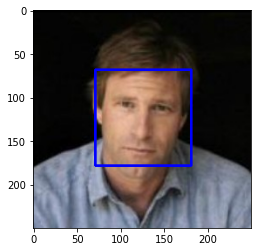

In [3]:
import cv2                
import matplotlib.pyplot as plt                        
%matplotlib inline                               

# extract pre-trained face detector
face_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_alt.xml')

# load color (BGR) image
img = cv2.imread(human_files[0])
# convert BGR image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# find faces in image
faces = face_cascade.detectMultiScale(gray)

# print number of faces detected in the image
print('Number of faces detected:', len(faces))

# get bounding box for each detected face
for (x,y,w,h) in faces:
    # add bounding box to color image
    cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    
# convert BGR image to RGB for plotting
cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# display the image, along with bounding box
plt.imshow(cv_rgb)
plt.show()

Before using any of the face detectors, it is standard procedure to convert the images to grayscale.  The `detectMultiScale` function executes the classifier stored in `face_cascade` and takes the grayscale image as a parameter.  

In the above code, `faces` is a numpy array of detected faces, where each row corresponds to a detected face.  Each detected face is a 1D array with four entries that specifies the bounding box of the detected face.  The first two entries in the array (extracted in the above code as `x` and `y`) specify the horizontal and vertical positions of the top left corner of the bounding box.  The last two entries in the array (extracted here as `w` and `h`) specify the width and height of the box.

### Writing a Human Face Detector

We can use this procedure to write a function that returns `True` if a human face is detected in an image and `False` otherwise.  This function, aptly named `face_detector`, takes a string-valued file path to an image as input and appears in the code block below.

In [4]:
# returns "True" if face is detected in image stored at img_path
def face_detector(img_path):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray)
    return len(faces) > 0

### Assessing the Human Face Detector

Ideally, we would like 100% of human images with a detected face and 0% of dog images with a detected face.  We observe that our algorithm falls short of this goal, but still gives acceptable performance.  We extract the file paths for the first 100 images from each of the datasets and store them in the numpy arrays `human_files_short` and `dog_files_short`.

In [6]:
from tqdm import tqdm

human_files_short = human_files[:100]
dog_files_short = dog_files[:100]

## Testing the performance of the face_detector algorithm 
## on the images in human_files_short and dog_files_short.
h_percent = 0
d_percent = 0
for i in human_files_short:
    if face_detector(i) == True:
        h_percent += 1
for i in dog_files_short:
    if face_detector(i) == True:
        d_percent += 1
print("Accuracy at human faces: %s" %h_percent)
print("Accuracy at dog faces: %s" %d_percent)

Accuracy at human faces: 97
Accuracy at dog faces: 18


---
<a id='step2'></a>
## Step 2: Detect Dogs

In this section, we use a [pre-trained model](http://pytorch.org/docs/master/torchvision/models.html) to detect dogs in images.  

### Obtain Pre-trained VGG-16 Model

The code cell below downloads the VGG-16 model, along with weights that have been trained on [ImageNet](http://www.image-net.org/), a very large, very popular dataset used for image classification and other vision tasks.  ImageNet contains over 10 million URLs, each linking to an image containing an object from one of [1000 categories](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a).  

In [7]:
import torch
import torchvision.models as models

# define VGG16 model
VGG16 = models.vgg16(pretrained=True)

# check if CUDA is available
use_cuda = torch.cuda.is_available()

# move model to GPU if CUDA is available
if use_cuda:
    VGG16 = VGG16.cuda()

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /home/coddiw0mple/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

In [8]:
use_cuda # True if CUDA is available :)

True

Given an image, this pre-trained VGG-16 model returns a prediction (derived from the 1000 possible categories in ImageNet) for the object that is contained in the image.

### Making Predictions with a Pre-trained Model

In the next code cell, we will write a function that accepts a path to an image (such as `'dogImages/train/001.Affenpinscher/Affenpinscher_00001.jpg'`) as input and returns the index corresponding to the ImageNet class that is predicted by the pre-trained VGG-16 model.  The output should always be an integer between 0 and 999, inclusive.

In [7]:
from PIL import Image
import torchvision.transforms as transforms

def VGG16_predict(img_path):
    '''
    Use pre-trained VGG-16 model to obtain index corresponding to 
    predicted ImageNet class for image at specified path
    
    Args:
        img_path: path to an image
        
    Returns:
        Index corresponding to VGG-16 model's prediction
    '''
    
    img = Image.open(img_path)
    
    transform = transforms.Compose([transforms.Resize(256),
                                    transforms.CenterCrop(224),
                                    transforms.ToTensor(),
                                    transforms.Normalize(mean=[0.5, 0.5, 0.5],
                                                         std=[0.25, 0.25, 0.25])])
    
    tr_img = transform(img)
    tr_batch = tr_img.unsqueeze(0)
    
    VGG16.eval() # Setting the model in eval mode
    
    out = VGG16(tr_batch.cuda())
    index = out.data.cpu().numpy().argmax()
    
    return index # predicted class index

### Write a Dog Detector

While looking at the [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a), we will notice that the categories corresponding to dogs appear in an uninterrupted sequence and correspond to dictionary keys 151-268, inclusive, to include all categories from `'Chihuahua'` to `'Mexican hairless'`.  Thus, in order to check to see if an image is predicted to contain a dog by the pre-trained VGG-16 model, we need only check if the pre-trained model predicts an index between 151 and 268 (inclusive).

Using this we create the `dog_detector` function below, which returns `True` if a dog is detected in an image (and `False` if not).

In [8]:
### returns "True" if a dog is detected in the image stored at img_path
def dog_detector(img_path):
    if VGG16_predict(img_path) in range(151,269):
        return True
    else:
        return False # true/false

### Assessing the Dog Detector

In [9]:
h_percent = 0
d_percent = 0
for i in human_files_short:
    if dog_detector(i) == True:
        h_percent += 1
for i in dog_files_short:
    if dog_detector(i) == True:
        d_percent += 1
print("Accuracy at human faces: %s" %h_percent)
print("Accuracy at dog faces: %s" %d_percent)

Accuracy at human faces: 0
Accuracy at dog faces: 99


---
<a id='step3'></a>
## Step 3: Creating a CNN to Classify Dog Breeds (from Scratch)

Now that we have functions for detecting humans and dogs in images, we need a way to predict breed from images.  In this step, we will create a CNN that classifies dog breeds.  We are creating our own CNN _from scratch_ (so, we can't use transfer learning _yet_!), and then we shall check the test accuracy. It will probably be low due to the CNN being trained on my local machine. In Step 4 of this notebook, we will use transfer learning to create a CNN that attains greatly improved accuracy.

We mention that the task of assigning breed to dogs from images is considered exceptionally challenging.  To see why, consider that *even a human* would have trouble distinguishing between a Brittany and a Welsh Springer Spaniel.  

Brittany | Welsh Springer Spaniel
- | - 
<img src="images/Brittany_02625.jpg" width="100"> | <img src="images/Welsh_springer_spaniel_08203.jpg" width="200">

It is not difficult to find other dog breed pairs with minimal inter-class variation (for instance, Curly-Coated Retrievers and American Water Spaniels).  

Curly-Coated Retriever | American Water Spaniel
- | -
<img src="images/Curly-coated_retriever_03896.jpg" width="200"> | <img src="images/American_water_spaniel_00648.jpg" width="200">


Likewise, recall that labradors come in yellow, chocolate, and black.  Our vision-based algorithm will have to conquer this high intra-class variation to determine how to classify all of these different shades as the same breed.  

Yellow Labrador | Chocolate Labrador | Black Labrador
- |
<img src="images/Labrador_retriever_06457.jpg" width="150"> | <img src="images/Labrador_retriever_06455.jpg" width="240"> | <img src="images/Labrador_retriever_06449.jpg" width="220">

We should also mention that random chance presents an exceptionally low bar: setting aside the fact that the classes are slightly imabalanced, a random guess will provide a correct answer roughly 1 in 133 times, which corresponds to an accuracy of less than 1%.  

### Specifying Data Loaders for the Dog Dataset

In [11]:
import os
from torchvision import datasets
import torchvision.transforms as transforms
import torch
import numpy as np
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

batch_size = 20
num_workers = 0

data_dir = './data/dog_images/'
train_dir = os.path.join(data_dir, 'train/')
valid_dir = os.path.join(data_dir, 'valid/')
test_dir = os.path.join(data_dir, 'test/')

standard_normalization = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                              std=[0.229, 0.224, 0.225])

data_transforms = {'train': transforms.Compose([transforms.RandomResizedCrop(224),
                                     transforms.RandomHorizontalFlip(),
                                     transforms.ToTensor(),
                                     standard_normalization]),
                   'val': transforms.Compose([transforms.Resize(256),
                                     transforms.CenterCrop(224),
                                     transforms.ToTensor(),
                                     standard_normalization]),
                   'test': transforms.Compose([transforms.Resize(size=(224,224)),
                                     transforms.ToTensor(), 
                                     standard_normalization])
                  }

train_data = datasets.ImageFolder(train_dir, transform=data_transforms['train'])
valid_data = datasets.ImageFolder(valid_dir, transform=data_transforms['val'])
test_data = datasets.ImageFolder(test_dir, transform=data_transforms['test'])

train_loader = torch.utils.data.DataLoader(train_data,
                                           batch_size=batch_size, 
                                           num_workers=num_workers,
                                           shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_data,
                                           batch_size=batch_size, 
                                           num_workers=num_workers,
                                           shuffle=False)
test_loader = torch.utils.data.DataLoader(test_data,
                                           batch_size=batch_size, 
                                           num_workers=num_workers,
                                           shuffle=False)
loaders_scratch = {
    'train': train_loader,
    'valid': valid_loader,
    'test': test_loader
}

**Points to note**:

1) Why  are we re-importing modules and defining image-paths again? We did it so we could come back to this problem and simply run one code block(this one) to get back on track

2) Images are resized to 256 px and then cropped to 224x224. Reducing the size of the image makes for a better crop as it can hold more of the original image inside. The images are cropped as having smaller image input vectors reduces processing time. Test images are directly reduced to 224x224 px so as to not lose any image data

3) We also augmented the train dataset through RandomHorizontalFlip() and RandomRotation()

### Model Architecture

Creating a CNN to classify dog breed.

In [12]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True


num_classes = len(train_data.classes)
num_classes

133

In [13]:

import torch.nn as nn
import torch.nn.functional as F
import numpy as np

# define the CNN architecture
class Net(nn.Module):
    def __init__(self):
        
        super(Net, self).__init__()
        ## Define layers of a CNN
        self.conv1 = nn.Conv2d(3, 32, 3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, stride=2, padding=1)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)

        # pool
        self.pool = nn.MaxPool2d(2, 2)
        
        # fully-connected
        self.fc1 = nn.Linear(7*7*128, 500)
        self.fc2 = nn.Linear(500, num_classes) 
        
        # drop-out
        self.dropout = nn.Dropout(0.3)
    
    def forward(self, x):
        ## Define forward behavior
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = F.relu(self.conv3(x))
        x = self.pool(x)
        
        # flatten
        x = x.view(-1, 7*7*128)
        
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# instantiate the CNN
model_scratch = Net()

# move tensors to GPU if CUDA is available
if use_cuda:
    model_scratch.cuda()

In [14]:
model_scratch

Net(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=6272, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=133, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)

**Points to note:**

1. In the first convolutional layer, I increase the depth from 3 (RGB) to 16. With each convolutional layer, the depth increases by a factor of two, going from 32 -> 64 -> 128. With each successive convolutional layer, the maxpool layer downsampled the image by a factor of 2. 3 layers were added to detect more complex patterns and shapes. 


2. 25% dropout rate added to prevent overfitting.


3. In the end, 2 linear layers will produce the final output size (num_classes) which predicts the different classes of breeds (133 breeds)

### Specify Loss Function and Optimizer

In [63]:
import torch.optim as optim

### Loss function
criterion_scratch = nn.CrossEntropyLoss()

### Optimizer
optimizer_scratch = optim.SGD(model_scratch.parameters(), lr=0.05)

### Train and Validate the Model

We train and validate our model in the code cell below. We also [save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at filepath `'model_scratch.pt'` so that they can be used with C++ in the future if needed.

In [67]:
def train(n_epochs, loaders, model, optimizer, criterion, use_cuda, save_path):
    """returns trained model"""
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf 
    
    for epoch in range(1, n_epochs+1):
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        
        ###################
        # train the model #
        ###################
        model.train()
        for batch_idx, (data, target) in enumerate(loaders['train']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            ## find the loss and update the model parameters accordingly
            ## record the average training loss, using something like
            ## train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            
            
        ######################    
        # validate the model #
        ######################
        model.eval()
        for batch_idx, (data, target) in enumerate(loaders['valid']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            ## update the average validation loss
            output = model(data)
            loss = criterion(output, target)
            valid_loss += loss.item()
            
        train_loss = train_loss/len(loaders['train'].dataset)
        valid_loss = valid_loss/len(loaders['valid'].dataset)
        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, 
            train_loss,
            valid_loss
            ))
        
        ## save the model if validation loss has decreased
        if valid_loss <= valid_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}).    Saving model...'.
                 format(valid_loss_min, valid_loss))
            torch.save(model.state_dict(), save_path)
            valid_loss_min = valid_loss
            
    # return trained model
    return model


# train the model
model_scratch = train(20, loaders_scratch, model_scratch, optimizer_scratch, 
                      criterion_scratch, use_cuda, 'model_scratch.pt')


Epoch: 1 	Training Loss: 0.202502 	Validation Loss: 0.192550
Validation loss decreased (inf --> 0.192550).    Saving model...
Epoch: 2 	Training Loss: 0.199890 	Validation Loss: 0.194395
Epoch: 3 	Training Loss: 0.198289 	Validation Loss: 0.201794
Epoch: 4 	Training Loss: 0.196071 	Validation Loss: 0.186976
Validation loss decreased (0.192550 --> 0.186976).    Saving model...
Epoch: 5 	Training Loss: 0.193926 	Validation Loss: 0.183893
Validation loss decreased (0.186976 --> 0.183893).    Saving model...
Epoch: 6 	Training Loss: 0.190761 	Validation Loss: 0.181524
Validation loss decreased (0.183893 --> 0.181524).    Saving model...
Epoch: 7 	Training Loss: 0.189348 	Validation Loss: 0.180594
Validation loss decreased (0.181524 --> 0.180594).    Saving model...
Epoch: 8 	Training Loss: 0.186386 	Validation Loss: 0.177412
Validation loss decreased (0.180594 --> 0.177412).    Saving model...
Epoch: 9 	Training Loss: 0.184375 	Validation Loss: 0.174647
Validation loss decreased (0.177412 

In [68]:
# load the model that got the best validation accuracy
model_scratch.load_state_dict(torch.load('model_scratch.pt'))

### Test the Model

Let's try out our model on the test dataset of dog images.  We use the code cell below to calculate and print the test loss and accuracy.

In [69]:
def test(loaders, model, criterion, use_cuda):

    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.

    model.eval()
    for batch_idx, (data, target) in enumerate(loaders['test']):
        # move to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data - test_loss))
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
            
    print('Test Loss: {:.6f}\n'.format(test_loss))

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))

# call test function
test(loaders_scratch, model_scratch, criterion_scratch, use_cuda)

Test Loss: 3.427846


Test Accuracy: 19% (161/836)


This looks really disheartening at first, but we have to realize that we have trained a small 3-layer CNN for only 20 epochs. 19% is still a great accuracy for this type of model!

---
<a id='step4'></a>
## Step 4: Create a CNN to Classify Dog Breeds (using Transfer Learning)

We will now use transfer learning to create a CNN that can identify dog breed from images.  It shall be much more accurate at this task.

### Specify Data Loaders for the Dog Dataset

In [12]:
transfer_loaders = loaders_scratch.copy()

In [13]:
class_names = [item[4:].replace("_", " ") for item in transfer_loaders['train'].dataset.classes]

In [14]:
class_names[:10]

['Affenpinscher',
 'Afghan hound',
 'Airedale terrier',
 'Akita',
 'Alaskan malamute',
 'American eskimo dog',
 'American foxhound',
 'American staffordshire terrier',
 'American water spaniel',
 'Anatolian shepherd dog']

In [ ]:
f = open('')

### Model Architecture

Finally we use transfer learning to create a CNN to classify dog breed. We save our initialized model as the variable `model_transfer`. While we could just use the VGG pretrained model to classify breeds in the given range, we are aiming at implementing transfer learning here which can be used for different tasks such as detecting skin cancer! (I shall be uploading the project on that later)

In [9]:
import torchvision.models as models
import torch.nn as nn

# Using the Resned50 model this time to switch up things
model_transfer = models.resnet50(pretrained = True)

for param in model_transfer.parameters():
    param.requires_grad = False
    
model_transfer.fc = nn.Linear(2048, 133, bias = True)

fc_parameters = model_transfer.fc.parameters()

for param in fc_parameters:
    param.requires_grad = True
    

if use_cuda:
    model_transfer = model_transfer.cuda()

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.torch/models/resnet50-19c8e357.pth
100%|██████████| 102502400/102502400 [00:01<00:00, 100454958.27it/s]


In [17]:
model_transfer

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=F

**Points to note:**

1. Here I chose resnet50 as an appropriate model as it has one of the best performances in image classification and I wanted to try something other than VGG16. Resnet has a feature that skips layers during backpropagation which probably reduces overfitting when training. 


2. I replaced the last fully connected layer to have 133 output nodes (for 133 breeds)

### Specifying Loss Function and Optimizer

We use the next code cell to specify a [loss function](http://pytorch.org/docs/master/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/master/optim.html). 

In [10]:
from torch import optim
criterion_transfer = nn.CrossEntropyLoss()
optimizer_transfer = optim.SGD(model_transfer.fc.parameters(), lr = 0.01)

### Train and Validate the Model

We train and validate our model in the code cell below.  Like before, we save the final model parameters at filepath `'model_transfer.pt'`.

In [81]:
# train the model
#model_transfer = # train(n_epochs, loaders_transfer, model_transfer, optimizer_transfer, criterion_transfer, use_cuda, 'model_transfer.pt')

def train(n_epochs, loaders, model, optimizer, criterion, use_cuda, save_path):
    """returns trained model"""
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf 
    
    for epoch in range(1, n_epochs+1):
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        
        ###################
        # train the model #
        ###################
        model.train()
        for batch_idx, (data, target) in enumerate(loaders['train']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            ## find the loss and update the model parameters accordingly
            ## record the average training loss, using something like
            ## train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            
            
        ######################    
        # validate the model #
        ######################
        model.eval()
        for batch_idx, (data, target) in enumerate(loaders['valid']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            ## update the average validation loss
            output = model(data)
            loss = criterion(output, target)
            valid_loss += loss.item()
            
        train_loss = train_loss/len(loaders['train'].dataset)
        valid_loss = valid_loss/len(loaders['valid'].dataset)
        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, 
            train_loss,
            valid_loss
            ))
        
        ## Save the model if validation loss has decreased
        if valid_loss <= valid_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}).    Saving model...'.
                 format(valid_loss_min, valid_loss))
            torch.save(model.state_dict(), save_path)
            valid_loss_min = valid_loss
            
    # return trained model
    return model
# load the model that got the best validation accuracy (uncomment the line below)
#model_transfer.load_state_dict(torch.load('model_transfer.pt'))

In [83]:
train(20, transfer_loaders, t_model, optimizer_transfer, criterion_transfer, use_cuda, 'model_transfer.pt')

Epoch: 1 	Training Loss: 0.092952 	Validation Loss: 0.056073
Validation loss decreased (inf --> 0.056073).    Saving model...
Epoch: 2 	Training Loss: 0.080575 	Validation Loss: 0.046379
Validation loss decreased (0.056073 --> 0.046379).    Saving model...
Epoch: 3 	Training Loss: 0.071265 	Validation Loss: 0.040362
Validation loss decreased (0.046379 --> 0.040362).    Saving model...
Epoch: 4 	Training Loss: 0.066572 	Validation Loss: 0.036312
Validation loss decreased (0.040362 --> 0.036312).    Saving model...
Epoch: 5 	Training Loss: 0.061600 	Validation Loss: 0.034154
Validation loss decreased (0.036312 --> 0.034154).    Saving model...
Epoch: 6 	Training Loss: 0.059368 	Validation Loss: 0.031826
Validation loss decreased (0.034154 --> 0.031826).    Saving model...
Epoch: 7 	Training Loss: 0.055752 	Validation Loss: 0.029512
Validation loss decreased (0.031826 --> 0.029512).    Saving model...
Epoch: 8 	Training Loss: 0.052506 	Validation Loss: 0.028334
Validation loss decreased (

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=F

In [11]:
model_transfer.load_state_dict(torch.load('model_transfer.pt'))

### Test the Model

Finally it's time to try out our model on the test dataset of dog images!

In [110]:
test(transfer_loaders, model_transfer, criterion_transfer, use_cuda)

Test Loss: 0.489143


Test Accuracy: 85% (717/836)


Oh great! It has an accuracy of 85% which is an amazing jump from a mere 19%!

This shows us how good transfer learning works. If we could have chosen different loss functions and optimizers and tune our hyperparameters we could very well push this number over 90%

### Predicting Dog Breed with the Model

Here we write a function that takes an image path as input and returns the dog breed (`Affenpinscher`, `Afghan hound`, etc) that is predicted by our model.  

In [14]:
# list of class names by index, i.e. a name can be accessed like class_names[0]
class_names = [item[4:].replace("_", " ") for item in transfer_loaders['train'].dataset.classes]

from PIL import Image
import torchvision.transforms as transforms

def predict_breed_transfer(img_path):
    img = Image.open(img_path).convert('RGB')
    transform_predict = transforms.Compose([transforms.Resize(256),
                                            transforms.CenterCrop(224),
                                            transforms.ToTensor(),
                                            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                                 std=[0.229, 0.224, 0.225])])
    
    img = transform_predict(img).unsqueeze(0)
    model_transfer.eval()
    idx = torch.argmax(model_transfer(img.cuda()))
    return class_names[idx]

In [15]:
class_names

['Affenpinscher',
 'Afghan hound',
 'Airedale terrier',
 'Akita',
 'Alaskan malamute',
 'American eskimo dog',
 'American foxhound',
 'American staffordshire terrier',
 'American water spaniel',
 'Anatolian shepherd dog',
 'Australian cattle dog',
 'Australian shepherd',
 'Australian terrier',
 'Basenji',
 'Basset hound',
 'Beagle',
 'Bearded collie',
 'Beauceron',
 'Bedlington terrier',
 'Belgian malinois',
 'Belgian sheepdog',
 'Belgian tervuren',
 'Bernese mountain dog',
 'Bichon frise',
 'Black and tan coonhound',
 'Black russian terrier',
 'Bloodhound',
 'Bluetick coonhound',
 'Border collie',
 'Border terrier',
 'Borzoi',
 'Boston terrier',
 'Bouvier des flandres',
 'Boxer',
 'Boykin spaniel',
 'Briard',
 'Brittany',
 'Brussels griffon',
 'Bull terrier',
 'Bulldog',
 'Bullmastiff',
 'Cairn terrier',
 'Canaan dog',
 'Cane corso',
 'Cardigan welsh corgi',
 'Cavalier king charles spaniel',
 'Chesapeake bay retriever',
 'Chihuahua',
 'Chinese crested',
 'Chinese shar-pei',
 'Chow cho

In [134]:
for img_file in os.listdir('./images'):
    img_path = os.path.join('./images', img_file)
    prediction = predict_breed_transfer(img_path)
    print("image_file_name: {0}, \nPredicted breed: {1} \n".format(img_path, prediction))

image_file_name: ./images/Welsh_springer_spaniel_08203.jpg, 
Predicted breed: Irish red and white setter 

image_file_name: ./images/Brittany_02625.jpg, 
Predicted breed: Brittany 

image_file_name: ./images/Labrador_retriever_06449.jpg, 
Predicted breed: Labrador retriever 

image_file_name: ./images/Curly-coated_retriever_03896.jpg, 
Predicted breed: Curly-coated retriever 

image_file_name: ./images/sample_cnn.png, 
Predicted breed: Chihuahua 

image_file_name: ./images/Labrador_retriever_06455.jpg, 
Predicted breed: Labrador retriever 

image_file_name: ./images/Labrador_retriever_06457.jpg, 
Predicted breed: Labrador retriever 

image_file_name: ./images/sample_dog_output.png, 
Predicted breed: Great dane 

image_file_name: ./images/sample_human_output.png, 
Predicted breed: English toy spaniel 

image_file_name: ./images/American_water_spaniel_00648.jpg, 
Predicted breed: Curly-coated retriever 



---
<a id='step5'></a>
## Step 5: Write your Algorithm

Here we write an algorithm that accepts a file path to an image and first determines whether the image contains a human, dog, or neither.  Then,
- if a __dog__ is detected in the image, returns the predicted breed.
- if a __human__ is detected in the image, returns the resembling dog breed.
- if __neither__ is detected in the image, provides output that indicates an error.
 

Some sample output for our algorithm is provided below

![Sample Human Output](./images/sample_human_output.png)


### Writing our Algorithm

In [17]:

def run_app(img_path):
    ## handle cases for a human face, dog, and neither
    img = Image.open(img_path).convert('RGB')
    plt.imshow(img)
    plt.show()
    #x = torch.to_tensor(img)
    #x = x[:3]
    # Using code from the beginning of the notebook
    if dog_detector(img_path) is True:
        prediction = predict_breed_transfer(img_path)
        print("Bleep Bloop Bleep...it's a doggo!\nIt looks like a {0}".format(prediction))
    elif face_detector(img_path) > 0:
        prediction = predict_breed_transfer(img_path)
        print("Hello, human!\nYou look like a {0}".format(prediction))
    else:
        print("Error! It's an alien or Mark Zuckerberg")


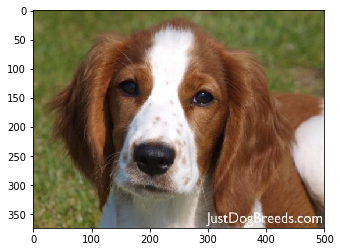

Bleep Bloop Bleep...it's a doggo!
It looks like a Irish red and white setter


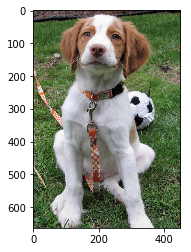

Bleep Bloop Bleep...it's a doggo!
It looks like a Brittany


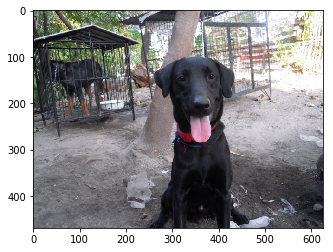

Bleep Bloop Bleep...it's a doggo!
It looks like a Labrador retriever


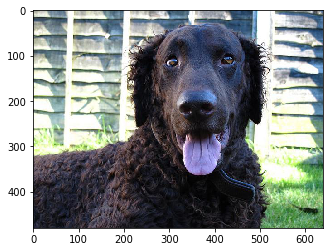

Bleep Bloop Bleep...it's a doggo!
It looks like a Curly-coated retriever


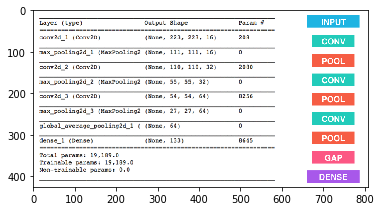

Error! It's an alien or Mark Zuckerberg


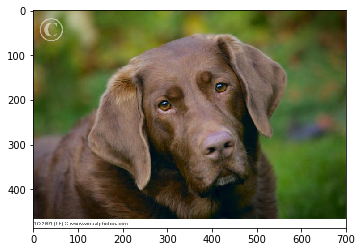

Bleep Bloop Bleep...it's a doggo!
It looks like a Labrador retriever


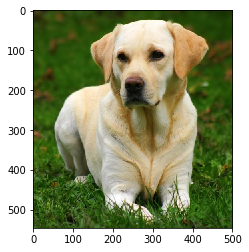

Bleep Bloop Bleep...it's a doggo!
It looks like a Labrador retriever


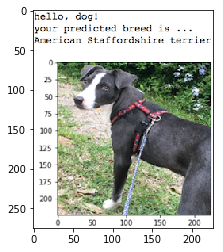

Error! It's an alien or Mark Zuckerberg


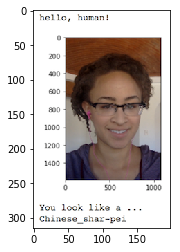

Error! It's an alien or Mark Zuckerberg


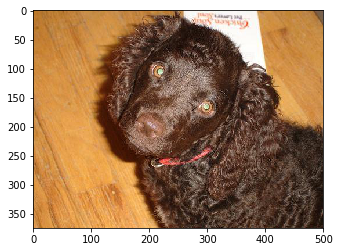

Bleep Bloop Bleep...it's a doggo!
It looks like a Curly-coated retriever


In [152]:
for img_file in os.listdir('./images'):
    img_path = os.path.join('./images', img_file)
    try:
        run_app(img_path)
    except:
        print("Error! It's an alien or Mark Zuckerberg")

---
<a id='step6'></a>
## Step 6: Testing our Algorithm

In this section, we will take our new algorithm for a spin! 
Let us test our algorithm on some images on our computer

**Points to note:**

1. Output was better than expected (and it's always fun to see in on humans)

**Some possible ways for improvement:**

1. A bigger dataset, though takes longer to train, is always gonna improve training models.

2. More image augmentation functions would help the network to train better (such as more rotation)

3. Model seems to classify humans based on their hairstyle. Would be ideal to find a way to circumvent this process and instead make predictions based on facial characteristics

4. Hyper-parameter tuning, like adjusting batch_size, n_epochs, different optimizers(Adam instead of SGD)

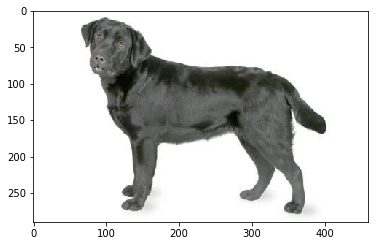

Bleep Bloop Bleep...it's a doggo!
It looks like a Flat-coated retriever


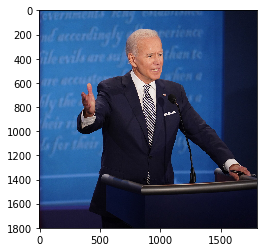

Hello, human!
You look like a Norwich terrier


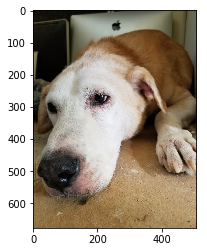

Bleep Bloop Bleep...it's a doggo!
It looks like a American staffordshire terrier


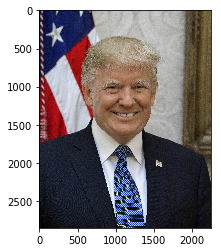

Hello, human!
You look like a Norfolk terrier


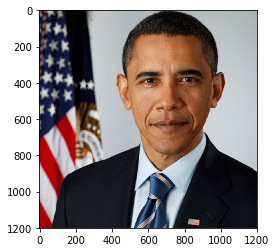

Hello, human!
You look like a Norwich terrier


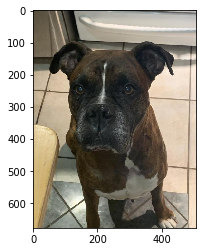

Bleep Bloop Bleep...it's a doggo!
It looks like a Boxer


In [19]:

for img_file in os.listdir('./test-images'):
    img_path = os.path.join('./test-images', img_file)
    run_app(img_path)
